# Project 1 - Aurèle Bohbot, Quentin Guilhot, Yanis Tournier

## Loading used libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from numpy import where
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVC, SVC, LinearSVR, NuSVR
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

## Data Extraction:

In [44]:
X = pd.read_csv('X_train.csv')
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530', 'id']
X_train_final = X.drop(columns=to_drop)
X_test_final = Xt.drop(columns=to_drop)
y_train_final = y.drop(columns=['id']) 

## Data cleaning:

In [45]:
## Using KNN to fill missing values:
imp_mean = IterativeImputer(missing_values=np.nan, sample_posterior=False, max_iter=10, tol=0.001, n_nearest_features=5, initial_strategy='mean', imputation_order='ascending', skip_complete=False, min_value=-np.inf, max_value=np.inf, verbose=1, random_state=None, add_indicator=False)
X_train_filled = imp_mean.fit_transform(X)
X_test_filled = imp_mean.fit_transform(Xt)

[IterativeImputer] Completing matrix with shape (1212, 833)
[IterativeImputer] Change: 7.116247559509567e+22, scaled tolerance: 9.935455099994669e+20 
[IterativeImputer] Change: 7.116247559509567e+22, scaled tolerance: 9.935455099994669e+20 
[IterativeImputer] Change: 7.116247559509593e+22, scaled tolerance: 9.935455099994669e+20 
[IterativeImputer] Change: 7.116247559509593e+22, scaled tolerance: 9.935455099994669e+20 
[IterativeImputer] Change: 622938747.1573031, scaled tolerance: 9.935455099994669e+20 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (776, 833)
[IterativeImputer] Change: 12456274.408192422, scaled tolerance: 2.035981960426312e+20 
[IterativeImputer] Early stopping criterion reached.


In [46]:
## Normalizing data
scaler = StandardScaler()
scaler.fit(X_train_filled)
X_train_norm = scaler.transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)
print(X_train_norm.shape,X_test_norm.shape)

(1212, 833) (776, 833)


## Feature selction:

In [47]:
select_feature = SelectKBest(f_regression, k=(160)).fit(X_train_norm, y_train_final)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)
print(X_train_new.shape,X_test_new.shape)

(1212, 160) (776, 160)


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


## Outlier detection:

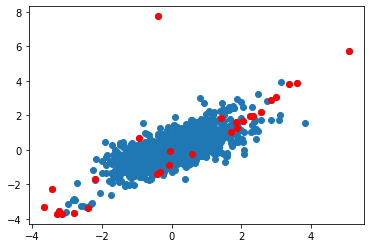

(29, 160) (1212, 160)
(1183, 160) (1183, 1)


In [48]:
## Outlier detection with multivariate technique: LOF
elenv = LocalOutlierFactor(n_neighbors=55)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)

X_train_less_outliers = np.delete(X_train_new,anom_index, axis=0)
Y_train_less_outliers = np.delete(y_train_final.values,anom_index, axis=0)
print(X_train_less_outliers.shape,Y_train_less_outliers.shape)

## Model training and predicting y:

In [49]:
r1 = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
r2 = SVR(kernel='rbf', gamma=0.01, tol=0.001, C=1000, epsilon=0.01, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
r3 = NuSVR(nu=0.2, C=1000, kernel='rbf', degree=3, gamma='scale', coef0=0.1, shrinking=True, tol=0.001, cache_size=200, verbose=False, max_iter=-1)
r4 = XGBRegressor(n_estimators=1000, learning_rate=0.02, n_jobs=4)
r5 = HistGradientBoostingRegressor(loss='squared_error', learning_rate=0.05, max_iter=1000, max_leaf_nodes=31, max_depth=None, min_samples_leaf=15, l2_regularization=0.1, max_bins=255, categorical_features=None, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)
regr = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3), ('abr', r4), ('HGB', r5)], weights=[1,3,1,2,1],n_jobs=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Exporting predictions:

In [50]:
pd.DataFrame({'id': [float(i) for i in range(y_pred.size)], 'y': y_pred}).to_csv('Prediction.csv')